/tmp/ipykernel_23733/2479285422.py:27: DtypeWarning: Columns (28,30,32,34,36,38,40,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  steamboat_climate_df = pd.read_csv(SteamboatClimateURL,


Missing TMAX values: 368
Filtered Date range: 1908-09-02 00:00:00 to 2024-09-18 00:00:00


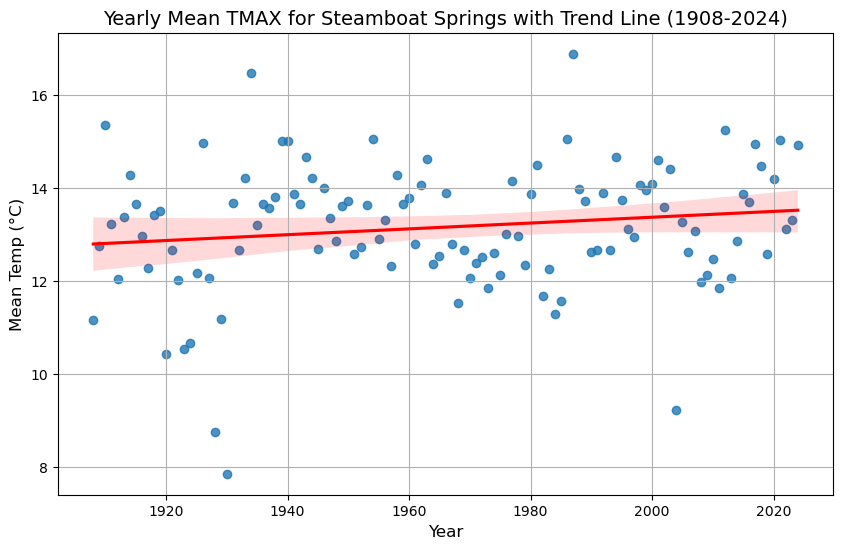

OLS Model Summary:
                            OLS Regression Results                            
Dep. Variable:                   TMAX   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.813
Date:                Fri, 27 Sep 2024   Prob (F-statistic):             0.0962
Time:                        20:33:05   Log-Likelihood:                -201.31
No. Observations:                 117   AIC:                             406.6
Df Residuals:                     115   BIC:                             412.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8482      7.341 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Having problems with code like this due to site timeout
# Read Global Historical Climatology Network daily (GHCNd) for the
# station with the largest dataset in Steamboat Springs, Colorado
# ran ok on 9/26, timing out on 9/27
# SteamboatTempURL = ('https://www.ncei.noaa.gov/access/services/data/v1?'
#    'dataset=daily-summaries'
#    '&dataTypes=TMAX'
#    '&dataTypes=TMIN'
#    '&stations=USC00057936'
#    '&startDate=1893-02-01'
#    '&endDate=2024-09-25'
#    '&units=metric')
# Google Drive file ID downloaded on 2024-09-19
file_id = '1tXD2YGxhEwXQ83UDxvad_co0fUc4Dn9m'

# Create a URL for direct download
SteamboatClimateURL = f'https://drive.google.com/uc?id={file_id}'

# Read the data from the CSV file
steamboat_climate_df = pd.read_csv(SteamboatClimateURL,
                                   index_col='DATE', 
                                   parse_dates=True, 
                                   na_values=['NaN'])

# Ensure that the index is properly converted to DatetimeIndex
steamboat_climate_df.index = pd.to_datetime(steamboat_climate_df.index, errors='coerce')

# Filter the data to only include rows from September 1908 onwards as before then 
# appears to have problems from 1893 to 1898 then no data till 1908
start_date = '1908-09-01'
steamboat_climate_df = steamboat_climate_df[steamboat_climate_df.index >= start_date]

# Check for missing data in TMAX
print("Missing TMAX values:", steamboat_climate_df['TMAX'].isna().sum())

# Drop rows where TMAX is NaN to avoid issues with plotting
steamboat_climate_df = steamboat_climate_df.dropna(subset=['TMAX'])

# Check the date range of the data to ensure it continues past 1908
print("Filtered Date range:", steamboat_climate_df.index.min(), "to", steamboat_climate_df.index.max())

# Resample data to yearly frequency and calculate the mean for TMAX
steamboat_yearly_mean_df = steamboat_climate_df['TMAX'].resample('YS').mean()

# Remove rows with missing or infinite values
steamboat_yearly_mean_df = steamboat_yearly_mean_df.replace([np.inf, -np.inf], np.nan).dropna()

# Create a 'Year' column from the index for regression
steamboat_yearly_mean_df = steamboat_yearly_mean_df.reset_index()
steamboat_yearly_mean_df['Year'] = steamboat_yearly_mean_df['DATE'].dt.year

# Plot the yearly mean TMAX with a trend line
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='Year', y='TMAX', data=steamboat_yearly_mean_df, line_kws={'color': 'red'})
plt.title('Yearly Mean TMAX for Steamboat Springs with Trend Line (1908-2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Temp (°C)', fontsize=12)
plt.grid(True)
plt.show()

# Prepare data for OLS Regression
X = steamboat_yearly_mean_df[['Year']]  # Predictor variable (Year)
y = steamboat_yearly_mean_df['TMAX']  # Response variable (Temperature)

# Add a constant (intercept term) to the predictor
X_ols = sm.add_constant(X)

# Fit the OLS model
model_ols = sm.OLS(y, X_ols).fit()

# Print the OLS model summary
print("OLS Model Summary:")
print(model_ols.summary())

# Extract the slope and intercept for OLS
slope_ols = model_ols.params['Year']
intercept_ols = model_ols.params['const']
print(f"Slope (OLS): {slope_ols:.4f} °C/year")
print(f"Intercept (OLS): {intercept_ols:.4f} °C")

# Consider using Ridge Regression
ridge_model = Ridge(alpha=1.0)  # You can adjust alpha to control the regularization strength
ridge_model.fit(X, y)

# Print Ridge model parameters
print("\nRidge Regression Coefficients:")
print(f"Slope (Ridge): {ridge_model.coef_[0]:.4f} °C/year")
print(f"Intercept (Ridge): {ridge_model.intercept_:.4f} °C")

# Consider using Lasso Regression
lasso_model = Lasso(alpha=0.1)  # You can adjust alpha to control the regularization strength
lasso_model.fit(X, y)

# Print Lasso model parameters
print("\nLasso Regression Coefficients:")
print(f"Slope (Lasso): {lasso_model.coef_[0]:.4f} °C/year")
print(f"Intercept (Lasso): {lasso_model.intercept_:.4f} °C")
